In [ ]:
#Import all the libs we need
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import os
import gym
import numpy as np
import random
import tensorflow.compat.v1 as tf
from collections import deque
import pickle

In [ ]:
from google.colab import drive

drive.mount('./content')

Mounted at ./content


In [ ]:
os.mkdir("checkpoints")
os.mkdir("roms")
os.mkdir("results")

In [ ]:
!unrar x "/content/content/MyDrive/Reinforcement_Learning/Roms.rar" "/content/roms"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/content/MyDrive/Reinforcement_Learning/Roms.rar

Extracting  /content/roms/HC ROMS.zip                                     36%  OK 
Extracting  /content/roms/ROMS.zip                                        74% 99%  OK 
All OK


In [ ]:
!python -m atari_py.import_roms /content/roms

copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/assault.bin
copying asterix.bin from ROMS/Asterix (AKA Taz) (07-27-1983) (Atari, Jerome Domurat, Steve Woita) (CX2696) (Prototype).bin to /usr/local/lib/python3.7/dist-packages/a

In [ ]:
"""Create two environments, env_1 is the environment of screen frame, env_2 is the environment of RAM """
env_1 = gym.make("Asterix-v0")
env_2 = gym.make("Asterix-ram-v0")

In [ ]:
"""Print the brief of actions and observations spaces of both environments"""
print(f"The observation space of env_1: {env_1.observation_space}")
print(f"The observation space of env_2: {env_2.observation_space}")
print()
print(f"The action space of env_1: {env_1.action_space}")
print(f"The action space of env_2: {env_2.action_space}")
print()
print(f"The meaning of actions in env_1: {env_1.unwrapped.get_action_meanings()}")
print(f"The meaning of actions in env_2: {env_2.unwrapped.get_action_meanings()}")

The observation space of env_1: Box(0, 255, (210, 160, 3), uint8)
The observation space of env_2: Box(0, 255, (128,), uint8)

The action space of env_1: Discrete(9)
The action space of env_2: Discrete(9)

The meaning of actions in env_1: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']
The meaning of actions in env_2: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


In [ ]:
print("Observation space:", env_1.observation_space)
print("Action space:", env_1.action_space)
print("Ram Observation space:", env_2.observation_space)
print("Ram Action space:", env_2.action_space)

Observation space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(9)
Ram Observation space: Box(0, 255, (128,), uint8)
Ram Action space: Discrete(9)


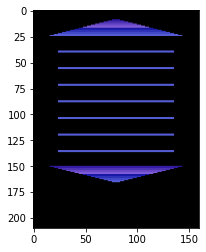

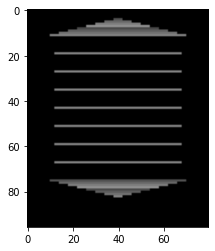

In [ ]:
obs_1 = env_1.reset()

def preprocess_observation(observation):
    img = observation[1:192:2, ::2] #This becomes 96, 80,3
    img = img.mean(axis=2) #to grayscale (values between 0 and 255)
    img = (img - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(96, 80, 1)

plt.imshow(obs_1)
plt.show()
plt.imshow(preprocess_observation(obs_1).reshape(96,80), cmap='gray', vmin=-128, vmax=127)
plt.show()

In [ ]:
def preprocess_observation_ram(observation):
  obs_2=observation/255.
  return obs_2

In [ ]:
preprocess_observation_ram(env_2.observation_space.sample())

array([0.00784314, 0.88235294, 0.11372549, 0.55294118, 0.74509804,
       0.75686275, 0.78039216, 0.27843137, 0.22745098, 0.98039216,
       0.        , 0.91372549, 0.84705882, 0.52941176, 0.76862745,
       0.37647059, 0.        , 0.02745098, 0.12156863, 0.13333333,
       0.56470588, 0.23137255, 0.68627451, 0.81176471, 0.12941176,
       0.56470588, 0.41176471, 0.43529412, 0.58431373, 0.9372549 ,
       0.9372549 , 0.4745098 , 0.38039216, 0.67843137, 0.74117647,
       0.15294118, 0.40784314, 0.90980392, 0.34117647, 0.89411765,
       0.54117647, 0.23529412, 0.38823529, 0.76470588, 0.85490196,
       0.83529412, 0.88627451, 0.02352941, 0.76078431, 0.52941176,
       0.31764706, 0.37254902, 0.08235294, 0.09803922, 0.02745098,
       0.41568627, 0.84313725, 0.36470588, 0.14901961, 0.91764706,
       1.        , 0.29803922, 0.50196078, 0.17254902, 0.61176471,
       0.05490196, 0.58431373, 0.85098039, 0.2       , 0.32941176,
       0.18431373, 0.41176471, 0.69803922, 0.80392157, 0.18823

## Q-Learning with Prioritized Experience Replay

Instead of randomly picking an experience batch from the experience replay buffer, we will attach a priority to each experience based on the value of the error, i.e. the difference between the target value and the value returned by the q-table.

In [ ]:
class PrioritizedReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        self.priorities = deque(maxlen=maxlen)
        
    #A new experience is given the maximum priority
    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))
        
    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities
    
    def get_importance(self, probabilities):
        importance = 1/(len(self.buffer) *probabilities)
        importance_normalized = importance / max(importance)
        return importance_normalized
        
    def sample(self, batch_size, priority_scale=1.0):
        sample_size = min(len(self.buffer), batch_size)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k=sample_size, weights=sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return map(list, zip(*samples)), importance, sample_indices
    
    def set_priorities(self, indices, errors, offset=0.001):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

# 1. The agent of conv network 

In [ ]:
#Build the Conv network for Task1
def pixel_model(X_state, name):
    prev_layer = X_state / 255.0   # scale the values to the [0, 1.0].
    initializer = tf.variance_scaling_initializer()
    with tf.variable_scope(name) as scope:
    # Build the conv layers
        prev_layer = tf.layers.conv2d(prev_layer, filters=32, 
                                      kernel_size=8,strides=4,
                                      padding="SAME" ,
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        prev_layer = tf.layers.conv2d(prev_layer, filters=64,
                                      kernel_size=4,strides=2,
                                      padding="SAME" ,
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        prev_layer = tf.layers.conv2d(prev_layer, filters=64,
                                      kernel_size=3,strides=1,
                                      padding="SAME" , 
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        
        #flatten the shape of previous layer
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1,64 * 12 * 10])
        # Fully connect layer
        hidden = tf.layers.dense(last_conv_layer_flat,512,
                                 activation=tf.nn.relu,
                                 kernel_initializer=initializer)
        #Last layer, output the action
        outputs = tf.layers.dense(hidden, env_1.action_space.n,kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [ ]:
class QLearningAgent():
    def __init__(self,env_1):
        #set the loss and error to infinity
        self.loss_val = np.infty
        self.error_val = np.infty

        #Observation space: Box(0, 255, (210, 160, 3), uint8),Action space: Discrete(9)
        self.action_size = env_1.action_space.n
        self.observation_size = env_1.observation_space.shape

        tf.reset_default_graph()
        tf.disable_eager_execution()
        #Set our learning rate and discount rate.
        self.learning_rate = 0.0001
        self.discount_rate = 0.97
        self.checkpoint_path = "checkpoints/screen.ckpt"
        #Set the min epsilon and max epsilon
        self.min_epsilon =0.1
        self.epsilon = self.max_epsilon = 1.0
        self.final_explore = 100000
        #Experience buffer
        self.replay_buffer = PrioritizedReplayBuffer(maxlen=1000)
        
        #input the shape of [96,80,1]
        self.X_state = tf.placeholder(tf.float32, shape=[None,96,80,1])

        #Get the q_values and vars of our two models:online,target
        self.online_q_values,self.online_vars = pixel_model(self.X_state,name="online")
        self.target_q_values, self.target_vars = pixel_model(self.X_state,name="target")
        
        #The "target" DNN will take the values of the "online" DNN
        self.copy_ops = [targ_var.assign(self.online_vars[targ_name]) for targ_name,targ_var in self.target_vars.items()]
        self.copy_online_to_target = tf.group(*self.copy_ops)  
        
        #We create the model for training
        with tf.variable_scope("train"):
            self.X_action = tf.placeholder(tf.int32,shape = [None])
            self.y = tf.placeholder(tf.float32,shape = [None])
            self.importance = tf.placeholder(tf.float32,shape = [None])
            
            self.q_value = tf.reduce_sum(self.online_q_values * tf.one_hot(self.X_action, self.action_size),axis=1)
            
            #Error and loss function
            self.error = self.y - self.q_value
            self.loss = tf.reduce_mean(tf.multiply(tf.losses.huber_loss(self.y,self.q_value,reduction='none'),self.importance))
            
            #Use adam optimizer,global_step holds the total number of steps during training
            self.global_step = tf.Variable(0,trainable=False,name='global_step')
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            
            #Minimize the loss of our training
            self.training_op = self.optimizer.minimize(self.loss,global_step = self.global_step)

        # Saving the session
        self.saver = tf.train.Saver()
        self.sess = tf.Session()
        if os.path.isfile(self.checkpoint_path + ".index"):
            self.saver.restore(self.sess, self.checkpoint_path)
        else:
            self.sess.run(tf.global_variables_initializer())
            self.sess.run(self.copy_online_to_target)

    #---- CHOSSING ACTION ----  
    def get_action(self,state):
        q_values = self.online_q_values.eval(feed_dict={self.X_state: [state]})
        
        #Decrease epsilon
        self.epsilon = max(self.min_epsilon, self.max_epsilon - ((self.max_epsilon - self.min_epsilon)/self.final_explore)*self.global_step.eval())
        
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)   #Random action
        else:
            return np.argmax(q_values)# Optimal action
    
    #---- TRAINING ----
    def train(self,experience,batch_size=32,priority_scale=0.0):
        # We add the new experience in the replay buffer
        self.replay_buffer.add(experience)
        
        #We get a sample from the experience replay buffer
        (state,action,next_state,reward,done),importance,indices = self.replay_buffer.sample(batch_size,priority_scale=priority_scale)
        
        #We compute the q_targets for the experiences in the sample 
        next_q_values = self.target_q_values.eval(feed_dict={self.X_state:np.array(next_state)})
        #If done,set to 0
        next_q_values[done] = np.zeros([self.action_size])  
        
        #compute target values
        y_val = reward + self.discount_rate * np.max(next_q_values)
        #We update the weights of the layers we build
        importance = (importance**(1-self.epsilon)).reshape((importance.shape[0],))
        feed = {self.X_state : np.array(state),self.X_action:np.array(action),self.y : y_val, self.importance:importance}
        _,self.loss_val,self.error_val = self.sess.run([self.training_op,self.loss, self.error],feed_dict=feed)

        #We also need to update the priorities of the experiences that were in the sample
        self.replay_buffer.set_priorities(indices,self.error_val)
        

# Run the conv network

	Episode:327/500,	Step : 23251	Total Reward: 1.0
	Episode:328/500,	Step : 23307	Total Reward: 2.0
	Episode:329/500,	Step : 23364	Total Reward: 1.0
	Episode:330/500,	Step : 23440	Total Reward: 4.0
	Episode:331/500,	Step : 23514	Total Reward: 3.0
	Episode:332/500,	Step : 23557	Total Reward: 4.0
	Episode:333/500,	Step : 23617	Total Reward: 4.0
	Episode:334/500,	Step : 23708	Total Reward: 8.0
	Episode:335/500,	Step : 23792	Total Reward: 8.0
	Episode:336/500,	Step : 23846	Total Reward: 3.0
	Episode:337/500,	Step : 23899	Total Reward: 6.0
	Episode:338/500,	Step : 23955	Total Reward: 5.0
	Episode:339/500,	Step : 24014	Total Reward: 2.0
	Episode:340/500,	Step : 24081	Total Reward: 2.0
	Episode:341/500,	Step : 24148	Total Reward: 2.0
	Episode:342/500,	Step : 24206	Total Reward: 3.0
	Episode:343/500,	Step : 24265	Total Reward: 4.0
	Episode:344/500,	Step : 24331	Total Reward: 5.0
	Episode:345/500,	Step : 24386	Total Reward: 3.0
	Episode:346/500,	Step : 24475	Total Reward: 8.0
	Episode:347/500,	St

<function matplotlib.pyplot.show>

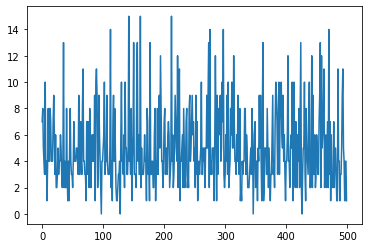

In [ ]:
agent = QLearningAgent(env_1)
episodes = 500
copy_steps = 10000
save_steps = 10000
ep_rewards = []
train_step=5
with agent.sess:
    for episode in range(1, episodes+1):
        state = preprocess_observation(env_1.reset())
        done = False
        total_reward = 0
        losses = []
        action = 0
        count=1
        
        while not done:
            step = agent.global_step.eval()
            ## Online DQN evaluates what to do
            #get action every 10 times of game
            if count%train_step==0:
              action = agent.get_action(state)
            
            #Online DQN plays
            next_state, reward, done, info = env_1.step(action)
            next_state = preprocess_observation(next_state)

            # re-scale the reward value, get 1 reward if the agent touch a cauldron 
            reward = reward/50

            #train every 10 times of game
            if count%train_step==0:
              agent.train((state,action,next_state,reward,done),priority_scale=0.8)
            
            state = next_state
            total_reward += reward
            
            # Regularly copy the online DQN to the target DQN
            if step%copy_steps == 0 :
                agent.copy_online_to_target.run()
            
            # Save regularly
            if step%save_steps == 0 :
                agent.saver.save(agent.sess,agent.checkpoint_path)
            count+=1
        print("\r\tEpisode:{}/{},\tStep : {}\tTotal Reward: {}".format(episode+1,episodes,step,total_reward))
        ep_rewards.append(total_reward)
        pickle.dump(ep_rewards,open("results/mix_pixel_game.p","wb"))

plt.plot(ep_rewards)
plt.show

# 2.Full connected network

In [ ]:
#Full connected neural network
def ram_model(X_state_ram, name):
    prev_layer = X_state_ram / 255.0 # scale the values to the [0, 1.0].
    initializer = tf.variance_scaling_initializer()
    #Build the fully connect layers, unit=128,activation function relu
    with tf.variable_scope(name) as scope:
        prev_layer = tf.layers.dense(prev_layer, 128, 
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        prev_layer = tf.layers.dense(prev_layer, 128,
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        prev_layer = tf.layers.dense(prev_layer, 128,
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        prev_layer = tf.layers.dense(prev_layer, 128,
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        #Final layer, output the action
        outputs = tf.layers.dense(prev_layer, env_2.action_space.n , kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [ ]:
class QLearningAgent_ram():
    def __init__(self,env_2):
        #Set the loss and error to infinity
        self.loss_val = np.infty
        self.error_val = np.infty

        #Ram Observation space: Box(0, 255, (128,), uint8),Ram Action space: Discrete(9)
        self.action_size = env_2.action_space.n
        self.observation_size = env_2.observation_space.shape

        tf.reset_default_graph()
        tf.disable_eager_execution()

        #Set our learning rate and discount rate.
        self.learning_rate = 0.0001
        self.discount_rate = 0.97
        self.checkpoint_path = "checkpoints/ram.ckpt"

        #Set the min epsilon and max epsilon
        self.min_epsilon =0.1
        self.epsilon = self.max_epsilon = 1.0
        self.final_explore = 100000
        #Experience buffer
        self.replay_buffer = PrioritizedReplayBuffer(maxlen=1000)
        
        #input the shape of (128,)
        self.X_state_ram = tf.placeholder(tf.float32, shape=[None,128])
        #Get the q_values and vars of our two models:online,target
        self.online_q_values,self.online_vars = ram_model(self.X_state_ram,name="online")
        self.target_q_values, self.target_vars = ram_model(self.X_state_ram,name="target")
        
        #The "target" DNN will take the values of the "online" DNN
        self.copy_ops = [targ_var.assign(self.online_vars[targ_name]) for targ_name,targ_var in self.target_vars.items()]
        self.copy_online_to_target = tf.group(*self.copy_ops)  
        
        #We create the model for training
        with tf.variable_scope("train"):
            self.X_action = tf.placeholder(tf.int32,shape = [None])
            self.y = tf.placeholder(tf.float32,shape = [None])
            self.importance = tf.placeholder(tf.float32,shape = [None])
            
            self.q_value = tf.reduce_sum(self.online_q_values * tf.one_hot(self.X_action, self.action_size),axis=1)
            
            #Error and loss function
            self.error = self.y - self.q_value
            self.loss = tf.reduce_mean(tf.multiply(tf.losses.huber_loss(self.y,self.q_value,reduction='none'),self.importance))
            
            #Use adam optimizer,global_step holds the total number of steps during training
            self.global_step = tf.Variable(0,trainable=False,name='global_step')
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            
            #Minimize the loss of our training
            self.training_op = self.optimizer.minimize(self.loss,global_step = self.global_step)

        # Saving the session
        self.saver = tf.train.Saver()
        self.sess = tf.Session()
        if os.path.isfile(self.checkpoint_path + ".index"):
            self.saver.restore(self.sess, self.checkpoint_path)
        else:
            self.sess.run(tf.global_variables_initializer())
            self.sess.run(self.copy_online_to_target)

    #---- CHOSSING ACTION ----   
    def get_action(self,state):
        q_values = self.online_q_values.eval(feed_dict={self.X_state_ram: [state]})
        
        #Decrease epsilon
        self.epsilon = max(self.min_epsilon, self.max_epsilon - ((self.max_epsilon - self.min_epsilon)/self.final_explore)*self.global_step.eval())   
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)   #Random action
        else:
            return np.argmax(q_values) # Optimal action
    
    #---- TRAINING ----
    def train(self,experience,batch_size=32,priority_scale=0.0):
        # We add the new experience in the replay buffer
        self.replay_buffer.add(experience)       
        
        #We get a sample from the experience replay buffer
        (state,action,next_state,reward,done),importance,indices = self.replay_buffer.sample(batch_size,priority_scale=priority_scale)
        
        #We compute the q_targets for the experiences in the sample
        next_q_values = self.target_q_values.eval(feed_dict={self.X_state_ram:np.array(next_state)})
        #If done,set to 0

        next_q_values[done] = np.zeros([self.action_size])   
        
        y_val = reward + self.discount_rate * np.max(next_q_values)
        #We update the weights of the layers we build
        importance = (importance**(1-self.epsilon)).reshape((importance.shape[0],))
        feed = {self.X_state_ram : np.array(state),self.X_action:np.array(action),self.y : y_val, self.importance:importance}
        _,self.loss_val,self.error_val = self.sess.run([self.training_op,self.loss, self.error],feed_dict=feed)
        #We also need to update the priorities of the experiences that were in the sample
        self.replay_buffer.set_priorities(indices,self.error_val)
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

`tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning:

`layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning:

`tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning:

`tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning:

`tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.

/usr/local

	Episode:2/500,	Step : 87	Total Reward: 7.0
	Episode:3/500,	Step : 158	Total Reward: 7.0
	Episode:4/500,	Step : 265	Total Reward: 15.0
	Episode:5/500,	Step : 312	Total Reward: 2.0
	Episode:6/500,	Step : 393	Total Reward: 4.0
	Episode:7/500,	Step : 445	Total Reward: 3.0
	Episode:8/500,	Step : 577	Total Reward: 16.0
	Episode:9/500,	Step : 633	Total Reward: 3.0
	Episode:10/500,	Step : 696	Total Reward: 4.0
	Episode:11/500,	Step : 762	Total Reward: 4.0
	Episode:12/500,	Step : 857	Total Reward: 8.0
	Episode:13/500,	Step : 924	Total Reward: 9.0
	Episode:14/500,	Step : 980	Total Reward: 4.0
	Episode:15/500,	Step : 1052	Total Reward: 6.0
	Episode:16/500,	Step : 1128	Total Reward: 5.0
	Episode:17/500,	Step : 1201	Total Reward: 7.0
	Episode:18/500,	Step : 1280	Total Reward: 10.0
	Episode:19/500,	Step : 1331	Total Reward: 1.0
	Episode:20/500,	Step : 1403	Total Reward: 5.0
	Episode:21/500,	Step : 1465	Total Reward: 4.0
	Episode:22/500,	Step : 1521	Total Reward: 2.0
	Episode:23/500,	Step : 1576	Tot

<function matplotlib.pyplot.show>

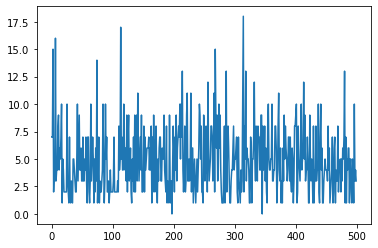

In [ ]:
agent = QLearningAgent_ram(env_2)
episodes = 500
copy_steps = 10000
save_steps = 10000
ep_rewards = []
train_step = 5
with agent.sess:
    for episode in range(1, episodes+1):
        state = preprocess_observation_ram(env_2.reset())
        done = False
        total_reward = 0
        losses = []
        count=1
        action = 0
        
        while not done:
            step = agent.global_step.eval()
            
            ## Online DQN evaluates what to do,every 10 train steps
            if count%train_step==0:
                action = agent.get_action(state)
            
            #Online DQN plays
            next_state, reward, done, info = env_2.step(action)
            next_state = preprocess_observation_ram(next_state)
            # re-scale the reward value, get 1 reward if the agent touch a cauldron 
            reward = reward/50           
            
            #train model every X frames(frame skipping):
            if count%train_step==0:
                agent.train((state,action,next_state,reward,done),priority_scale=0.8)
            
            state = next_state
            total_reward += reward
            
            # Regularly copy the online DQN to the target DQN
            if step%copy_steps == 0 :
                agent.copy_online_to_target.run()
            
            # Save regularly
            if step%save_steps == 0 :
                agent.saver.save(agent.sess,agent.checkpoint_path)
            
            count+=1
        print("\r\tEpisode:{}/{},\tStep : {}\tTotal Reward: {}".format(episode+1,episodes,step,total_reward))
        ep_rewards.append(total_reward)
    pickle.dump(ep_rewards,open("results/ram_game.p","wb"))

plt.plot(ep_rewards)
plt.show

# 3.Mixed network

In [ ]:
#Mixed network for task 3
def create_model_mixed(X_state,X_state_ram,name):
    prev_layer = X_state/255. # scale the values of each pixel to the [0, 1.0].
    ram_layer = X_state_ram/255.  # scale the values of each pixel to the [0, 1.0].
    initializer = tf.variance_scaling_initializer()
    #Build the model
    with tf.variable_scope(name) as scope:
        #for the pixel game, we use conv+dense
        prev_layer = tf.layers.conv2d(prev_layer, filters=32, 
                                      kernel_size=8,strides=4,
                                      padding="SAME" ,
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        prev_layer = tf.layers.conv2d(prev_layer, filters=64,
                                      kernel_size=4,strides=2,
                                      padding="SAME" ,
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        prev_layer = tf.layers.conv2d(prev_layer, filters=64,
                                      kernel_size=3,strides=1,
                                      padding="SAME" , 
                                      activation=tf.nn.relu,
                                      kernel_initializer=initializer)
        #faltten the shape of the prev_layer
        flatten = tf.reshape(prev_layer,shape=[-1,64*12*10])
        final_cnn_layer = tf.layers.dense(flatten,512,activation=tf.nn.relu,kernel_initializer=initializer)
        #Build the dense layers for the ram game
        ram_layer = tf.layers.dense(ram_layer,128,activation=tf.nn.relu,kernel_initializer=initializer)
        ram_layer = tf.layers.dense(ram_layer,128,activation=tf.nn.relu,kernel_initializer=initializer)
        #concat these two neural network
        concat = tf.concat([final_cnn_layer,ram_layer],1)
        #output the action
        output = tf.layers.dense(concat, 9,kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
    return output, trainable_vars_by_name

In [ ]:
class QLearningAgent_mix():
    def __init__(self,env_1,env_2):
        #set the loss and error to infinity
        self.loss_val = np.infty
        self.error_val = np.infty

        #Observation space: Box(0, 255, (210, 160, 3), uint8),Action space: Discrete(9)
        #Ram Observation space: Box(0, 255, (128,), uint8),Ram Action space: Discrete(9)
        self.action_size = env_2.action_space.n
        self.observation_size = env_2.observation_space.shape

        tf.reset_default_graph()
        tf.disable_eager_execution()
        #Set our learning rate and discount rate.
        self.learning_rate = 0.0001
        self.discount_rate = 0.97
        self.checkpoint_path = "checkpoints/mix.ckpt"

        #Set the min epsilon and max epsilon
        self.min_epsilon =0.1
        self.epsilon = self.max_epsilon = 1.0
        self.final_explore = 100000
        #Experience buffer
        self.replay_buffer = PrioritizedReplayBuffer(maxlen=1000)
        

        
        #input the shape of [96,80,1]-pixel game
        self.X_state = tf.placeholder(tf.float32, shape=[None, 96, 80, 1])
        #input the shape of (128,) ram game
        self.X_state_ram = tf.placeholder(tf.float32, shape=[None,128])

        #Get the q_values and vars of our two models:online,target
        self.online_q_values,self.online_vars = create_model_mixed(self.X_state, self.X_state_ram, name="online")
        self.target_q_values, self.target_vars = create_model_mixed(self.X_state, self.X_state_ram, name="target")
        
        #The "target" DNN will take the values of the "online" DNN
        self.copy_ops = [targ_var.assign(self.online_vars[targ_name]) for targ_name,targ_var in self.target_vars.items()]
        self.copy_online_to_target = tf.group(*self.copy_ops)  
        
        #We create the model for training
        with tf.variable_scope("train"):
            self.X_action = tf.placeholder(tf.int32,shape = [None])
            self.y = tf.placeholder(tf.float32,shape = [None])
            self.importance = tf.placeholder(tf.float32,shape = [None])
            
            self.q_value = tf.reduce_sum(self.online_q_values * tf.one_hot(self.X_action, self.action_size),axis=1)
            
            #Error and loss function
            self.error = self.y - self.q_value
            self.loss = tf.reduce_mean(tf.multiply(tf.losses.huber_loss(self.y,self.q_value,reduction='none'),self.importance))
            
            #Use adam optimizer,global_step holds the total number of steps during training
            self.global_step = tf.Variable(0,trainable=False,name='global_step')
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            
            #Minimize the loss of our training
            self.training_op = self.optimizer.minimize(self.loss,global_step = self.global_step)
        # Saving the session
        self.saver = tf.train.Saver()
        self.sess = tf.Session()
        if os.path.isfile(self.checkpoint_path + ".index"):
            self.saver.restore(self.sess, self.checkpoint_path)
        else:
            self.sess.run(tf.global_variables_initializer())
            self.sess.run(self.copy_online_to_target)

    #---- CHOSSING ACTION ----  
    def get_action(self,state_1, state_2):
        q_values = self.online_q_values.eval(feed_dict={self.X_state:[state_1], self.X_state_ram: [state_2]})
    
        #Decrease epsilon
        self.epsilon = max(self.min_epsilon, self.max_epsilon - ((self.max_epsilon - self.min_epsilon)/self.final_explore)*self.global_step.eval())
        
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)   #Random action
        else:
            return np.argmax(q_values)                  # Optimal action
    
    #---- TRAINING ----
    def train(self,experience,batch_size=32,priority_scale=0.0):
        # We add the new experience in the replay buffer
        self.replay_buffer.add(experience)        
        
        #extract an experience batch from the buffer
        (state_1, state_2,action,next_state_1, next_state_2,reward,done),importance,indices = self.replay_buffer.sample(batch_size,priority_scale=priority_scale)
        
        #We compute the q_targets for the experiences in the sample 
        next_q_values = self.target_q_values.eval(feed_dict={self.X_state:np.array(next_state_1), self.X_state_ram:np.array(next_state_2)})
        next_q_values[done] = np.zeros([self.action_size])   #If done,set to 0
        
        #compute target values
        y_val = reward + self.discount_rate * np.max(next_q_values)
        
         #We update the weights of the layers we build
        importance = (importance**(1-self.epsilon)).reshape((importance.shape[0],))
        feed = {self.X_state : np.array(state_1), self.X_state_ram : np.array(state_2),self.X_action:np.array(action),self.y : y_val, self.importance:importance}
        _,self.loss_val,self.error_val = self.sess.run([self.training_op,self.loss, self.error],feed_dict=feed)
        #We also need to update the priorities of the experiences that were in the sample
        self.replay_buffer.set_priorities(indices,self.error_val)
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. P

INFO:tensorflow:Restoring parameters from checkpoints/mix.ckpt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


	Episode:2/500,	Step : 30052	Total Reward: 1.0
	Episode:3/500,	Step : 30132	Total Reward: 7.0
	Episode:4/500,	Step : 30224	Total Reward: 8.0
	Episode:5/500,	Step : 30282	Total Reward: 2.0
	Episode:6/500,	Step : 30328	Total Reward: 2.0
	Episode:7/500,	Step : 30433	Total Reward: 12.0
	Episode:8/500,	Step : 30492	Total Reward: 4.0
	Episode:9/500,	Step : 30553	Total Reward: 6.0
	Episode:10/500,	Step : 30668	Total Reward: 11.0
	Episode:11/500,	Step : 30722	Total Reward: 2.0
	Episode:12/500,	Step : 30803	Total Reward: 4.0
	Episode:13/500,	Step : 30856	Total Reward: 5.0
	Episode:14/500,	Step : 30930	Total Reward: 6.0
	Episode:15/500,	Step : 30994	Total Reward: 3.0
	Episode:16/500,	Step : 31048	Total Reward: 3.0
	Episode:17/500,	Step : 31117	Total Reward: 1.0
	Episode:18/500,	Step : 31172	Total Reward: 3.0
	Episode:19/500,	Step : 31251	Total Reward: 7.0
	Episode:20/500,	Step : 31315	Total Reward: 3.0
	Episode:21/500,	Step : 31367	Total Reward: 2.0
	Episode:22/500,	Step : 31455	Total Reward: 11

<function matplotlib.pyplot.show>

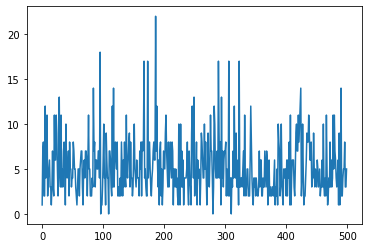

In [ ]:
agent = QLearningAgent_mix(env_1,env_2)
episodes = 500
copy_steps = 10000
save_steps = 10000
ep_rewards = []
train_step = 5
with agent.sess:
    for episode in range(1, episodes+1):
        #set the states of our envrionments
        state_1 = preprocess_observation(env_1.reset())
        state_2 = preprocess_observation_ram(env_2.reset())
        done = False
        total_reward = 0
        losses = []
        count=1
        action = 0
        
        while not done:
            step = agent.global_step.eval()
            
            #Get new action every 10 train steps
            if count%train_step==0:
                action = agent.get_action(state_1, state_2)
            
            #Online DQN plays
            #play in env_1
            next_state_1, reward, done, info = env_1.step(action)
            next_state_1 = preprocess_observation(next_state_1)

            #play in env_2
            next_state_2, _, _, _ = env_2.step(action)
            next_state_2 = preprocess_observation_ram(next_state_2)
            # re-scale the reward value, get 1 reward if the agent touch a cauldron 
            reward = reward/50              
            
            #train model every 10 train steps
            if count%train_step==0:
                agent.train((state_1, state_2, action, next_state_1, next_state_2,reward,done),priority_scale=0.8)
            
            state_1 = next_state_1
            state_2 = next_state_2
            total_reward += reward
            
            # Regularly copy the online DQN to the target DQN
            if step%copy_steps == 0 :
                agent.copy_online_to_target.run()
            
            # Save regularly
            if step%save_steps == 0 :
                agent.saver.save(agent.sess,agent.checkpoint_path)
            
            count+=1
        print("\r\tEpisode:{}/{},\tStep : {}\tTotal Reward: {}".format(episode+1,episodes,step,total_reward))
        ep_rewards.append(total_reward)
    pickle.dump(ep_rewards,open("results/mix_game.p","wb"))

#plt the figure
plt.plot(ep_rewards)
plt.show

In [ ]:
!zip -r checkpoints.zip ./checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/mix.ckpt.data-00000-of-00001 (deflated 26%)
  adding: checkpoints/ram.ckpt.data-00000-of-00001 (deflated 29%)
  adding: checkpoints/checkpoint (deflated 38%)
  adding: checkpoints/screen.ckpt.meta (deflated 90%)
  adding: checkpoints/mix.ckpt.meta (deflated 90%)
  adding: checkpoints/mix.ckpt.index (deflated 55%)
  adding: checkpoints/screen.ckpt.data-00000-of-00001 (deflated 22%)
  adding: checkpoints/ram.ckpt.index (deflated 56%)
  adding: checkpoints/ram.ckpt.meta (deflated 90%)
  adding: checkpoints/screen.ckpt.index (deflated 52%)


## Plot the Chart

In [ ]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd


In [ ]:
with open('mix_pixel_game.p', 'rb') as f:
    img_data = pickle.load(f)

with open('ram_game.p', 'rb') as f:
    ram_data = pickle.load(f)

with open('mix_game.p', 'rb') as f:
    mix_data = pickle.load(f)

In [ ]:
eposides_img = len(img_data)
eposides_ram = len(ram_data)
eposides_mix = len(mix_data)

In [ ]:
df1 = pd.DataFrame({'image_game_rewards': img_data, 'ram_game_rewards': ram_data, 'mix_game_rewards': mix_data})
df1['Episode'] = df1.index
df1

,image_game_rewards,ram_game_rewards,mix_game_rewards,Episode
0,7.0,2.0,1.0,0
1,8.0,5.0,7.0,1
2,5.0,4.0,8.0,2
3,4.0,6.0,2.0,3
4,3.0,3.0,2.0,4
...,...,...,...,...
495,4.0,6.0,5.0,495
496,1.0,2.0,8.0,496
497,4.0,4.0,3.0,497
498,4.0,3.0,3.0,498


In [ ]:
data = img_data + ram_data + mix_data

df2 = pd.DataFrame({'rewards':data})
df2['game_mode'] = 'img_mode'

In [ ]:
df2.iloc[500:1000]['game_mode'] = 'ram_mode'
df2.iloc[1000:1500]['game_mode'] = 'mix_mode'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df2['episodes'] = [i+1 for i in range(1500)]

In [ ]:
df2.iloc[500:1000]['episodes'] = [i+1 for i in range(500)]
df2.iloc[1000:1500]['episodes'] = [i+1 for i in range(500)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df2

,rewards,game_mode,episodes
0,7.0,img_mode,1
1,8.0,img_mode,2
2,5.0,img_mode,3
3,4.0,img_mode,4
4,3.0,img_mode,5
...,...,...,...
1495,5.0,mix_mode,496
1496,8.0,mix_mode,497
1497,3.0,mix_mode,498
1498,3.0,mix_mode,499


In [ ]:
"""Print the average reawrds of each mode"""
df1.mean()

image_game_rewards      5.052
ram_game_rewards        5.040
mix_game_rewards        5.202
Episode               249.500
dtype: float64

In [ ]:
"""Plot scatter to observe the rewards distribution of 500 episodes"""

# fig = px.scatter(df, x='Eposide', y='image_game_rewards', title='Rewards in Image Game')
# fig.show()

# fig = px.scatter(df, x='Eposide', y='ram_game_rewards', title='Rewards in RAM Game')
# fig.show()

# fig = px.scatter(df, x='Eposide', y='mix_game_rewards', title='Rewards in Mix Game')
# fig.show()
fig = px.scatter(df1, x='Episode', y='image_game_rewards')
fig.show()

fig = px.scatter(df1, x='Episode', y='ram_game_rewards')
fig.show()

fig = px.scatter(df1, x='Episode', y='mix_game_rewards')
fig.show()

In [ ]:
n = 100
rewards_img, rewards_ram, rewards_mix = df1['image_game_rewards'], df1['ram_game_rewards'], df1['mix_game_rewards']

# the mean of every 5 eposides
mean_ram = [rewards_ram[i:(i+5)].mean() for i in range(n)]
mean_img = [rewards_img[i:(i+5)].mean() for i in range(n)]
mean_mix = [rewards_mix[i:(i+5)].mean() for i in range(n)]

In [ ]:
df_mean = pd.DataFrame({'5_episodes_mean_img': mean_img, '5_episodes_mean_ram': mean_ram, '5_episodes_mean_mix': mean_mix})
df_mean['epochs'] = df_mean.index+1
df_mean

,5_episodes_mean_img,5_episodes_mean_ram,5_episodes_mean_mix,epochs
0,5.4,4.0,4.0,1
1,6.0,4.8,6.2,2
2,5.0,5.6,5.6,3
3,4.8,5.8,5.2,4
4,4.2,6.2,7.0,5
...,...,...,...,...
95,2.8,5.8,4.6,96
96,3.0,6.0,2.2,97
97,3.8,4.4,4.2,98
98,5.8,5.4,4.8,99


In [ ]:
mean_img = df_mean['5_episodes_mean_img']
mean_ram = df_mean['5_episodes_mean_ram']
mean_mix = df_mean['5_episodes_mean_mix']

mean = mean_img.append(mean_ram).append(mean_mix)
df_mean2 = pd.DataFrame({'5_episodes_mean_rewards': mean})
df_mean2

,5_episodes_mean_rewards
0,5.4
1,6.0
2,5.0
3,4.8
4,4.2
...,...
95,4.6
96,2.2
97,4.2
98,4.8


In [ ]:
df_mean2['mode'] = 'img'
df_mean2.iloc[100:200]['mode'] = 'ram'
df_mean2.iloc[200:300]['mode'] = 'mix'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_mean2['epochs'] = [i+1 for i in range(300)]
df_mean2.iloc[100:200]['epochs'] = [i+1 for i in range(100)]
df_mean2.iloc[200:300]['epochs'] = [i+1 for i in range(100)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
"""Plot scatter to observe the rewards distribution of 500 episodes"""

# fig = px.scatter(df_mean, y='5_eposides_mean_img', x='epochs', title='Every 5 episdoes Rewards in Image Game')
# fig.show()

# fig = px.scatter(df_mean, y='5_eposides_mean_ram', x='epochs', title='Every 5 episdoes Rewards in RAM Game')
# fig.show()

# fig = px.scatter(df_mean, y='5_eposides_mean_mix', x='epochs', title='Every 5 episdoes Rewards in Mix Game')
# fig.show()

fig = px.scatter(df_mean, y='5_episodes_mean_img', x='epochs')
fig.show()

fig = px.scatter(df_mean, y='5_episodes_mean_ram', x='epochs')
fig.show()

fig = px.scatter(df_mean, y='5_episodes_mean_mix', x='epochs')
fig.show()

In [ ]:
# fig = px.line(df_mean, y='5_episodes_mean_img', x='epochs', title='Every 5 episodes Rewards in Image Game')
# fig.show()

# fig = px.line(df_mean, y='5_episodes_mean_ram', x='epochs', title='Every 5 episodes Rewards in RAM Game')
# fig.show()

# fig = px.line(df_mean, y='5_episodes_mean_mix', x='epochs', title='Every 5 episodes Rewards in Mix Game')
# fig.show()

fig = px.line(df_mean, y='5_episodes_mean_img', x='epochs')
fig.show()

fig = px.line(df_mean, y='5_episodes_mean_ram', x='epochs')
fig.show()

fig = px.line(df_mean, y='5_episodes_mean_mix', x='epochs')
fig.show()

In [ ]:
df2

,rewards,game_mode,episodes
0,7.0,img_mode,1
1,8.0,img_mode,2
2,5.0,img_mode,3
3,4.0,img_mode,4
4,3.0,img_mode,5
...,...,...,...
1495,5.0,mix_mode,496
1496,8.0,mix_mode,497
1497,3.0,mix_mode,498
1498,3.0,mix_mode,499


In [ ]:
# fig = px.scatter(df2, x='episodes', y='rewards', color='game_mode', 
#                  title="Distribution-1 Img vs. RAM vs. Mix")
# fig.show()
fig = px.scatter(df2, x='episodes', y='rewards', color='game_mode')
fig.show()

In [ ]:
fig = px.violin(df2, x='game_mode', y='rewards')
fig.show()

In [ ]:
fig = px.box(df2, x='game_mode', y='rewards')
fig.show()

In [ ]:
# fig = px.line(df2, x='episodes', y='rewards', color='game_mode', 
#                  title="Distribution-2 Img vs. RAM vs. Mix")
# fig.show()
fig = px.line(df2, x='episodes', y='rewards', color='game_mode')
fig.show()

In [ ]:
import plotly.graph_objects as go

In [ ]:
x = df1['Episode']
# x = np.linspace(0, 500, 10)
img, ram, mix = df1['image_game_rewards'], df1['ram_game_rewards'], df1['mix_game_rewards']

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=img, mode='markers', name='img_mode'))
fig.add_trace(go.Scatter(x=x, y=ram, mode='markers+lines', name='ram_mode'))
fig.add_trace(go.Scatter(x=x, y=mix, mode='lines', name='mix_mode'))

fig.show()

In [ ]:
df_mean2

,5_episodes_mean_rewards,mode,epochs
0,5.4,img,1
1,6.0,img,2
2,5.0,img,3
3,4.8,img,4
4,4.2,img,5
...,...,...,...
95,4.6,mix,96
96,2.2,mix,97
97,4.2,mix,98
98,4.8,mix,99


In [ ]:
fig = px.scatter(df_mean2, x='epochs', y='5_episodes_mean_rewards', color='mode')
fig.show()

In [ ]:
fig = px.line(df_mean2, x='epochs', y='5_episodes_mean_rewards', color='mode')
fig.show()

In [ ]:
df1.to_csv('RewardsPerEpisode-1.csv')
df2.to_csv('RewardsPerEpisode-2.csv')
df_mean.to_csv('5MeanRewardsEpoch-1.csv')
df_mean2.to_csv('5MeanRewardsEpoch-2.csv')

In [ ]:
class RandomAgent():
    def __init__(self, env):
        self.action_size = env.action_space.n
        
    def get_action(self, observation):
        return random.choice(range(self.action_size))
    
total_reward=0
agent = RandomAgent(env_1)
numberOfEpisodes = 10
dict_list = []
for steps in range(numberOfEpisodes):
    current_obs = env_1.reset()
    done = False
    while not done:
        action = agent.get_action(current_obs)
        next_obs, reward, done, info = env_1.step(action)
        total_reward += reward
        dict_list.append(info)
        # env_1.render()
print("Average reward: {}".format(total_reward/numberOfEpisodes))

Average reward: 390.0


In [ ]:
dict_list

[{'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives': 3},
 {'ale.lives